In [ ]:
!pip install xgboost
!pip install pandas
!pip install regex
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 4.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
import re
import xgboost as xgb
from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from xgboost import plot_tree
from sklearn.metrics import accuracy_score, classification_report

# Load necessary NLTK data
nltk.download('stopwords')

# Mount Google Drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Mounted at /content/drive


In [ ]:
# Load the main dataset
data = pd.read_excel("/content/drive/MyDrive/daset/cek_xg.xlsx")

# Load the E-numbers dataset
e_numbers_df = pd.read_csv("/content/drive/MyDrive/daset/e_dataset.csv")

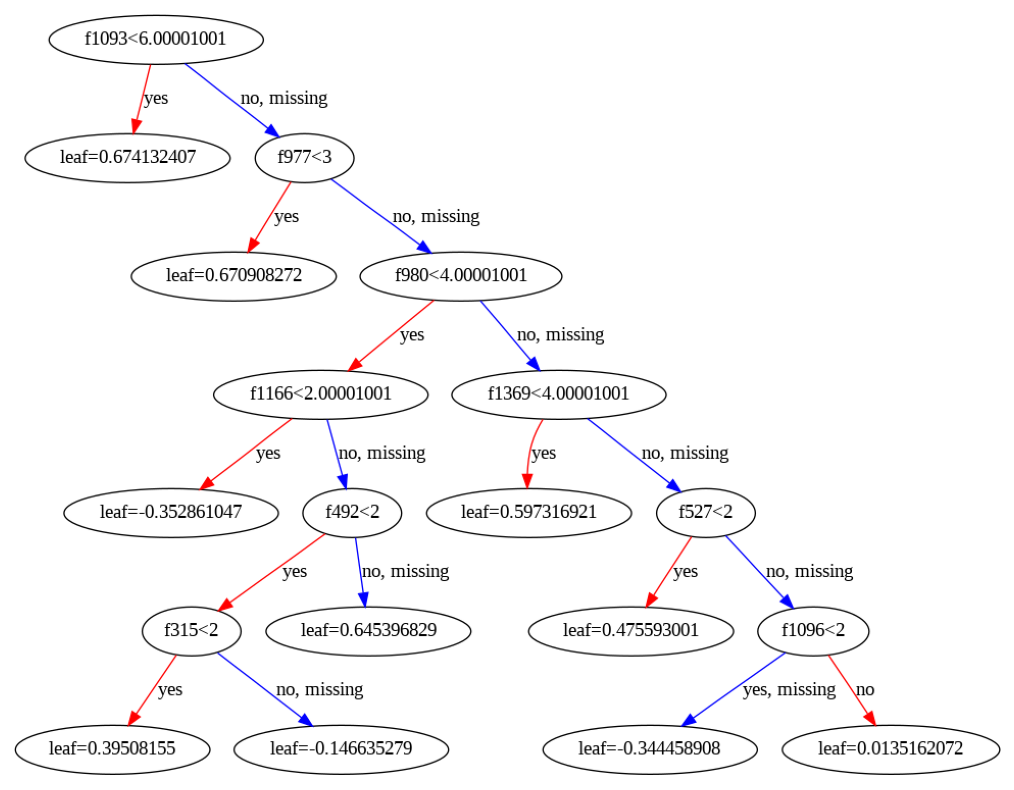

Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       162
           1       0.92      0.75      0.83       154

    accuracy                           0.85       316
   macro avg       0.86      0.85      0.85       316
weighted avg       0.86      0.85      0.85       316

Item: pork lard, E-number: no_e_number, Classification: Haram
Item: banana, E-number: no_e_number, Classification: Halal
Item: monosodium glutamate, E-number: E621, Classification: Halal


In [ ]:
# Convert to lowercase to ensure case-insensitive matching
data['Entitas'] = data['Entitas'].str.lower().str.strip()
e_numbers_df['description'] = e_numbers_df['description'].str.lower().str.strip()

# Preprocessing for the main dataset
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

data['Entitas'] = data['Entitas'].fillna('')

# Function to categorize entities based on descriptions in the E-numbers dataset
def categorize_e_numbers_by_description(entitas, e_numbers_df):
    for _, row in e_numbers_df.iterrows():
        e_number = row['e-number']
        description = row['description']
        # Debugging prints to ensure matching is working
        # print(f"Checking if '{description}' is in '{entitas}'")
        if description in entitas:
            return e_number
    return 'no_e_number'

# Apply categorization to the main dataset
data['e_number_category'] = data['Entitas'].apply(lambda x: categorize_e_numbers_by_description(x, e_numbers_df))

# Split data latih dan data uji
train_data, test_data, train_labels, test_labels = train_test_split(
    data['Entitas'], data['label'], test_size=0.3, random_state=42
)

# Convert text data to numerical features using CountVectorizer
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_data)
X_test = vectorizer.transform(test_data)

# Create and train the XGBoost model
model = XGBClassifier()
model.fit(X_train, train_labels)

# Show model
plt.figure(figsize=(20, 10))
plot_tree(model, num_trees=0, ax=plt.gca())
plt.show()

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(test_labels, predictions)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report
print(classification_report(test_labels, predictions))

# Function to predict the names of the labels for a list of food item strings
def predict_food_classification(food_descriptions):
    # Convert the input string into a list of food descriptions
    food_descriptions_list = [description.strip().lower() for description in food_descriptions.split(',')]

    # Transform each input string using the same vectorizer
    input_vectors = vectorizer.transform(food_descriptions_list)

    # Make predictions using the XGBoost model
    predicted_label_indices = model.predict(input_vectors)

    # Get the corresponding label names
    predicted_label_names = label_encoder.inverse_transform(predicted_label_indices)

    # Classify and display E-number category
    e_number_categories = [categorize_e_numbers_by_description(description, e_numbers_df) for description in food_descriptions_list]

    # Display results
    for description, label, e_number in zip(food_descriptions_list, predicted_label_names, e_number_categories):
        # Fixing the logic: Assuming 1 is Haram and 0 is Halal
        label_str = 'Haram' if label == 1 else 'Halal'
        print(f'Item: {description}, E-number: {e_number}, Classification: {label_str}')

    return predicted_label_names

# Example usage with multiple food descriptions as a single string
food_predictions = "pork lard, banana, monosodium glutamate"
predicted_labels = predict_food_classification(food_predictions)